In [27]:
#!pip install tensorflow_text

import math
import numpy as np
import pandas as pd
import csv
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import tensorflow_hub as hub
import tensorflow_text as text
import random

df_list = []

def label_type(row):
    #print(row['Type'])
    if row['Type'] == 'Conversation' :
      #print(0)
      return int(0)
    if row['Type'] == 'Intruction' :
      #print(1)
      return int(1)
    if row['Type'] == 'Strategy' :
      #print(2)
      return int(2)
    else:
      return int(3)

for i in range(1, 29):
    df = pd.read_csv('Data/Data '+str(i)+'.csv', sep=',')
    df['Num Type'] = df.apply(lambda row: label_type(row), axis=1)
    df_list.append(df)
    
data_indices = list(range(28))
random.shuffle(data_indices)

train_indices = data_indices[:14]
tuning_indices = data_indices[14:21]
testing_indices = data_indices[21:]

train_x = []
tuning_x = []
test_x = []

train_y = []
tuning_y = []
test_y = []

for i in train_indices:
    #print(i)
    df = df_list[i]
    for j in range(len(df)):
        #if(type(df['Utterance'][j]) == str and type(df['Type'][j]) == str):
        if(df['Num Type'][j] != 3):
          train_x.append(df['Utterance'][j])
          one_hot_label = [0, 0, 0]
          one_hot_index = int(df['Num Type'][j])
          one_hot_label[one_hot_index] = 1
          train_y.append(one_hot_label)
          #train_y.append(int(df['Num Type'][j]))
    

for i in tuning_indices:
    #print(i)
    df = df_list[i]
    for j in range(len(df)):
        #if(type(df['Utterance'][j]) == str and type(df['Type'][j]) == str):
        if(df['Num Type'][j] != 3):
          tuning_x.append(df['Utterance'][j])
          one_hot_label = [0, 0, 0]
          one_hot_index = int(df['Num Type'][j])
          one_hot_label[one_hot_index] = 1
          tuning_y.append(one_hot_label)
          #tuning_y.append(int(df['Num Type'][j]))
    
for i in testing_indices:
    #print(i)
    df = df_list[i]
    for j in range(len(df)):
        #if(type(df['Utterance'][j]) == str and type(df['Type'][j]) == str):
        if(df['Num Type'][j] != 3):
          test_x.append(df['Utterance'][j])
          one_hot_label = [0, 0, 0]
          one_hot_index = int(df['Num Type'][j])
          one_hot_label[one_hot_index] = 1
          test_y.append(one_hot_label)
          #test_y.append(int(df['Num Type'][j]))

#print(train_y)
#print(np.array(train_y).shape)

In [28]:
bert_preprocess_model = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_model = hub.KerasLayer('https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1')

encoder_inputs = bert_preprocess_model(train_x)
outputs = bert_model(encoder_inputs)
pooled_output = outputs["pooled_output"]
sequence_output = outputs["sequence_output"]

print(pooled_output)
#print(sequence_output)

tf.Tensor(
[[-0.9999991   0.06495295 -0.99964845 ...  0.999291    0.4007576
   0.98024917]
 [-0.99999917 -0.01363813 -0.9998662  ...  0.9426693   0.85433793
   0.99341595]
 [-0.99991035 -0.04171816 -0.99553466 ...  0.96192455  0.92402875
   0.9995595 ]
 ...
 [-0.9999986   0.10833754 -0.99982065 ...  0.9975987   0.68492496
   0.99724525]
 [-0.99999934  0.07703308 -0.9998719  ...  0.9961245   0.93768394
   0.9949839 ]
 [-0.9999932   0.08750622 -0.99884933 ...  0.9968769   0.9695488
   0.9865784 ]], shape=(1027, 128), dtype=float32)


Epoch 1/20
52/52 [==============================] - 1s 2ms/step - loss: 0.4854 - categorical_accuracy: 0.9723 - categorical_crossentropy: 0.4854
Epoch 2/20
52/52 [==============================] - 0s 1ms/step - loss: 0.1739 - categorical_accuracy: 0.9645 - categorical_crossentropy: 0.1739
Epoch 3/20
52/52 [==============================] - 0s 1ms/step - loss: 0.1320 - categorical_accuracy: 0.9743 - categorical_crossentropy: 0.1320
Epoch 4/20
52/52 [==============================] - 0s 2ms/step - loss: 0.1238 - categorical_accuracy: 0.9756 - categorical_crossentropy: 0.1238
Epoch 5/20
52/52 [==============================] - 0s 2ms/step - loss: 0.1399 - categorical_accuracy: 0.9704 - categorical_crossentropy: 0.1399
Epoch 6/20
52/52 [==============================] - 0s 2ms/step - loss: 0.1480 - categorical_accuracy: 0.9676 - categorical_crossentropy: 0.1480
Epoch 7/20
52/52 [==============================] - 0s 1ms/step - loss: 0.1138 - categorical_accuracy: 0.9771 - categorical_crosse

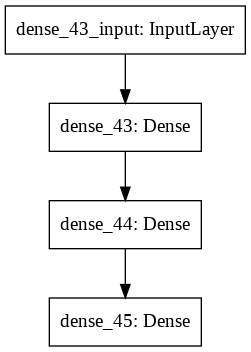

In [43]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(40, activation='sigmoid'))
model.add(tf.keras.layers.Dense(20, activation='sigmoid'))
model.add(tf.keras.layers.Dense(3, activation='softmax'))
model.compile(loss='CategoricalCrossentropy', optimizer='adam', metrics=['CategoricalAccuracy', 'CategoricalCrossentropy'])

y_pred = model.fit(pooled_output, np.array(train_y), epochs=20, batch_size=20)

print(y_pred)
tf.keras.utils.plot_model(model)

In [50]:
encoder_tuning = bert_preprocess_model(tuning_x)
outputs_tuning = bert_model(encoder_tuning)
pooled_output_tuning = outputs_tuning["pooled_output"]

y_tuning_pred = model.predict(pooled_output_tuning)
score_pred = tf.keras.losses.CategoricalCrossentropy()

print(y_tuning_pred)
print('\nTuning Categorical Cross Entropy:')
score_pred(tuning_y, y_tuning_pred).numpy()

[[9.55062389e-01 1.66236307e-03 4.32752892e-02]
 [9.26788390e-01 2.27857637e-03 7.09330216e-02]
 [9.49020982e-01 1.85750006e-03 4.91214842e-02]
 ...
 [8.92072082e-01 2.87015736e-03 1.05057664e-01]
 [9.82299268e-01 1.01113517e-03 1.66895408e-02]
 [9.87313688e-01 8.39197659e-04 1.18471133e-02]]

Tuning Categorical Cross Entropy:


0.110847555

In [58]:
def probability_class_assignment(vec):
  for i in range(len(vec)):
    if vec[i][0] > vec[i][1] and vec[i][0] > vec[i][2]:
      vec[i][0] = 1
      vec[i][1] = 0
      vec[i][2] = 0
    elif vec[i][1] > vec[i][2]:
      vec[i][0] = 0
      vec[i][1] = 1
      vec[i][2] = 0
    else:
      vec[i][0] = 0
      vec[i][1] = 0
      vec[i][2] = 1
  return np.array(vec)

y_tuning_pred_one_hot = probability_class_assignment(y_tuning_pred)
print(y_tuning_pred)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [64]:
tuning_counts = np.array(tuning_y).sum(axis=0)
tuning_counts_pred = y_tuning_pred_one_hot.sum(axis=0)

print('Original Count of Conversational Utterances:',tuning_counts[0])
print('Predicted Count of Conversational Utterances:',tuning_counts_pred[0])

print("Original Count of Instructional Utterances:",tuning_counts[1])
print("Predicted Count of Instructional Utterances:",tuning_counts_pred[1])

print("Original Count of Strategy Utterances",tuning_counts[2])
print("Predicted Count of Strategy Utterances",tuning_counts_pred[2])

[906   0  23]
[929.   0.   0.]
Original Count of Conversational Utterances: 906
Predicted Count of Conversational Utterances: 929.0
Original Count of Instructional Utterances: 0
Predicted Count of Instructional Utterances: 0.0
Original Count of Strategy Utterances 23
Predicted Count of Strategy Utterances 0.0


In [65]:
#Test Set
encoder_test = bert_preprocess_model(test_x)
outputs_test = bert_model(encoder_test)
pooled_output_test = outputs_test["pooled_output"]

y_test_pred = model.predict(pooled_output_test)

print(y_test_pred)
print('\nTuning Categorical Cross Entropy:')
score_pred(test_y, y_test_pred).numpy()

[[9.8616272e-01 8.8960264e-04 1.2947710e-02]
 [9.1338903e-01 2.4812615e-03 8.4129654e-02]
 [9.3281847e-01 2.0813078e-03 6.5100156e-02]
 ...
 [9.7835118e-01 1.1336766e-03 2.0515140e-02]
 [9.8481989e-01 9.3762111e-04 1.4242478e-02]
 [9.8620808e-01 8.8952517e-04 1.2902401e-02]]

Tuning Categorical Cross Entropy:


0.07577699

In [66]:
y_test_pred_one_hot = probability_class_assignment(y_test_pred)
print(y_test_pred)

test_counts = np.array(test_y).sum(axis=0)
test_counts_pred = y_test_pred_one_hot.sum(axis=0)

print('Original Count of Conversational Utterances:',test_counts[0])
print('Predicted Count of Conversational Utterances:',test_counts_pred[0])

print("Original Count of Instructional Utterances:",test_counts[1])
print("Predicted Count of Instructional Utterances:",test_counts_pred[1])

print("Original Count of Strategy Utterances",test_counts[2])
print("Predicted Count of Strategy Utterances",test_counts_pred[2])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
Original Count of Conversational Utterances: 675
Predicted Count of Conversational Utterances: 684.0
Original Count of Instructional Utterances: 0
Predicted Count of Instructional Utterances: 0.0
Original Count of Strategy Utterances 9
Predicted Count of Strategy Utterances 0.0
